# Analysis, detection & mitigation of felonious wallet accounts over the Ethereum Blockchain network using Machine Learning techniques

| BITS ID No. | Name of Student    | Email                          | Mobile     |
| ------------| ------------------ | ------------------------------ | ---------- |
| 2019HC04178 | Anjali Sunder Naik | sundernaik.anjali@in.bosch.com | 8147757114 |

# 1. Problem Statement

As of 2021, a survey from Coin Market Cap indicates that there are nearly over 6,000 digital coins in the market, a severe increase from just a handful since 2013. However, a large portion of these cryptocurrencies might not be that significant. The total market cap of all the crypto assets, including stable coins and tokens has shown a significant rise from year 2020 and has hit 2.4 trillion. Cryptocurrencies has vast potential of revolutionizing and transforming compliance-free peer-to-peer transactions. However, an end user must overcome certain challenges related to privacy, security, and control. As the transactions are recorded in a publicly distributed ledger known as blockchain, hackers have a large attack surface to gain access to critical and sensitive data. In the rapidly growing crypto currency space, the technological advent of cryptocurrencies and their respective benefits has been veiled with several illicit financing activities operating over the network such as ransomware, terrorist financing, hacking, data manipulation during transaction process, phishing, fraud, money laundering, bribery etc. Chainalysis, a firm that tracks every crypto currency transaction and serves as an advisor to an array of government authorities has published a report that shows that the amount of cryptocurrency spent on dark net markets rose 60% to reach a new high of $1.15billion from July 2020 to June 2021

# 2. Data Collection
1. What kind of problem are we trying to solve?
    - Fraud Detection, Categorical Analysis
2. What data sources already exist?
    - Ethereum Foundation Blacklist, Etherscan 
3. What privacy concerns are there?
    - NA
4. Is the data public?
    - Yes
5. Where should we store the files?
    - Local Store
6. What is the type of data collected?
    - Structured

# 3. Data Preparation

We collect the raw list of valid and invalid (blacklisted) ethereum accounts from ether scan, which are a combination of both EOA & Smart Contracts

In [180]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import requests

In [181]:
# constants
invalid_data_path = '../data/invalid/invalid.csv'
api_key = '8BPTQD7WQ9NK9IVRZHQEDIQMX4C6MDBQ3C'

## 3.1 Data Visualization

In [182]:
df = pd.read_csv(invalid_data_path)

print("Total number of felonious accounts in the dataset: ",df.shape[0])

df.head()

Total number of felonious accounts in the dataset:  6297


,Address,Name Tag,Balance,Txn Count,label
0,0x9f26ae5cd245bfeeb5926d61497550f79d9c6c1c,Akropolis Hacker 1,0 Ether,29,phish-hack
1,0xbceaa0040764009fdcff407e82ad1f06465fd2c4,Bancor Hacker,0 Ether,3,phish-hack
2,0x03b70dc31abf9cf6c1cf80bfeeb322e8d3dbb4ca,Browser Extension Hack,0 Ether,64,phish-hack
3,0x4639cd8cd52ec1cf2e496a606ce28d8afb1c792f,CBDAO: BREE Token,0 Ether,6897,phish-hack
4,0xeda5066780de29d00dfb54581a707ef6f52d8113,ChainSwap Hacker,0.11961143 Ether,771,phish-hack


<AxesSubplot:title={'center':'Felonious Ethereum Accounts data'}>

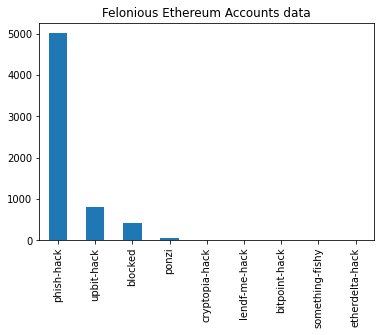

In [183]:
plt.title("Felonious Ethereum Accounts data")
df['label'].value_counts().plot(kind='bar')

## 3.2 Convert the address to lower case and remove duplicates

In [184]:
df.columns = df.columns.str.lower()
df2 = df.apply(lambda x: x.str.lower().str.strip() if x.dtype == "object" else x)
df2.head()

,address,name tag,balance,txn count,label
0,0x9f26ae5cd245bfeeb5926d61497550f79d9c6c1c,akropolis hacker 1,0 ether,29,phish-hack
1,0xbceaa0040764009fdcff407e82ad1f06465fd2c4,bancor hacker,0 ether,3,phish-hack
2,0x03b70dc31abf9cf6c1cf80bfeeb322e8d3dbb4ca,browser extension hack,0 ether,64,phish-hack
3,0x4639cd8cd52ec1cf2e496a606ce28d8afb1c792f,cbdao: bree token,0 ether,6897,phish-hack
4,0xeda5066780de29d00dfb54581a707ef6f52d8113,chainswap hacker,0.11961143 ether,771,phish-hack


## 3.3 Remove accounts with null transactions as they do not contribute to the cause

In [185]:
df3 = df2.drop(df2[df2['txn count'] == 0].index)
print("Total number of felonious accounts in the dataset: ",df3.shape[0])

Total number of felonious accounts in the dataset:  5270


## 3.3 Filter the addresses as EOA/Smart Contract

In [187]:
import statistics
import datetime
    
class EOA:
    def __init__(self,eoa_address,transactions):
        self.eoa_address = eoa_address.lower()
        self.transactions = transactions

    def f1_total_transactions_sent(self):
        return len([x for x in self.transactions if x['from'] == self.eoa_address])

    def f2_total_transactions_received(self):
        return len([x for x in self.transactions if x['to'] == self.eoa_address])

    def f3_value_out(self):
        return sum([int(x['value']) for x in self.transactions if x['from'] == self.eoa_address])
    
    def f4_value_in(self):
        return sum([int(x['value']) for x in self.transactions if x['to'] == self.eoa_address])
    
    def f5_value_difference(self):
        return abs(self.f3_value_out()-self.f4_value_in())
    
    def f6_number_of_distinct_address_contacted(self):
        seen = set()
        dupes = []
        for x in self.transactions:
            if (x['from'] == self.eoa_address and  x['to'] in seen) :
                dupes.append(x['to'])
            else:
                seen.add(x['to'])
            if (x['to'] == self.eoa_address and  x['from'] in seen) :
                dupes.append(x['from'])
            else:
                seen.add(x['from'])  
        return len(seen)-1
    
    def f7_total_transactions_sent_received(self):
        return self.f1_total_transactions_sent() + self.f2_total_transactions_received()
    
    def f8_total_transactions_sent_to_unique_address(self):
        all_transactions_sent = [x for x in self.transactions if x['from'] == self.eoa_address]
        seen = set()
        dupes = []
        for x in all_transactions_sent:
            if (x['to'] in seen) :
                dupes.append(x['to'])
            else:
                seen.add(x['to'])
        return len(seen)
    
    def f9_total_transactions_received_from_unique_address(self):
        all_transactions_sent = [x for x in self.transactions if x['to'] == self.eoa_address]
        seen = set()
        dupes = []
        for x in all_transactions_sent:
            if (x['from'] in seen) :
                dupes.append(x['from'])
            else:
                seen.add(x['from'])
        return len(seen)
    
    def f10_first_transaction_time(self):
        return self.transactions[0]['timeStamp']    
    
    def f11_last_transaction_time(self):
        return self.transactions[len(self.transactions)-1]['timeStamp']

    def f12_transction_active_duration(self):
        a = datetime.datetime.fromtimestamp(int(self.f10_first_transaction_time()))
        b = datetime.datetime.fromtimestamp(int(self.f11_last_transaction_time()))
        return (b-a).total_seconds()
    
    def f13_last_txn_bit(self):
        return self.transactions[len(self.transactions)-1]['txreceipt_status']    

    def f14_last_transaction_value(self):
        return self.transactions[len(self.transactions)-1]['value']

    def f15_average_incoming_ether(self):
        try:
            all_incoming_transactions = [x for x in self.transactions if x['to'] == self.eoa_address]
            return self.f4_value_in()/len(all_incoming_transactions)
        except:
            return 0
    
    def f16_average_outgoing_ether(self):
        try:
            all_outgoing_transactions = [x for x in self.transactions if x['from'] == self.eoa_address]
            return self.f3_value_out()/len(all_outgoing_transactions)
        except:
            return 0

    def f17_average_percentage_gas_incoming(self):
        total_incoming_gas = sum([int(x['gas']) for x in self.transactions if x['to'] == self.eoa_address])
        total_gas = sum([int(x['gas']) for x in self.transactions])
        return (total_incoming_gas/total_gas)*100

    def f18_average_percentage_gas_outgoing(self):
        total_outgoing_gas = sum([int(x['gas']) for x in self.transactions if x['from'] == self.eoa_address])
        total_gas = sum([int(x['gas']) for x in self.transactions])
        return (total_outgoing_gas/total_gas)*100
    
    def f19_outgoing_gas_price(self):
        return sum([int(x['gasPrice']) for x in self.transactions if x['from'] == self.eoa_address])

    def f20_incoming_gas_price(self):
        return sum([int(x['gasPrice']) for x in self.transactions if x['to'] == self.eoa_address])
# check
    def f21_average_incoming_gas_price(self):
        try:
            all_incoming_transactions = [x for x in self.transactions if x['to'] == self.eoa_address]
            return self.f20_incoming_gas_price()/len(all_incoming_transactions)
        except:
            return 0
# check    
    def f22_average_outgoing_gas_price(self):
        try:
            all_outgoing_transactions = [x for x in self.transactions if x['from'] == self.eoa_address]
            return self.f19_outgoing_gas_price()/len(all_outgoing_transactions)
        except:
            return 0
    
    def f23_total_failed_transactions_incoming(self):
        return len([x for x in self.transactions if x['txreceipt_status'] == '0' and x['to'] == self.eoa_address])
    
    def f24_total_failed_transactions_outgoing(self):
        return len([x for x in self.transactions if x['txreceipt_status'] == '0' and x['from'] == self.eoa_address])

    def f25_total_failed_transactions(self):
        return len([x for x in self.transactions if x['txreceipt_status'] == '0'])
    
    def f26_total_success_transactions_incoming(self):
        return len([x for x in self.transactions if x['txreceipt_status'] == '1' and x['to'] == self.eoa_address])
    
    def f27_total_success_transactions_outgoing(self):
        return len([x for x in self.transactions if x['txreceipt_status'] == '1' and x['from'] == self.eoa_address])
    
    def f28_total_success_transactions(self):
        return len([x for x in self.transactions if x['txreceipt_status'] == '1'])
    
    def f29_gas_used_incoming_transaction(self):
        return sum([int(x['gasUsed']) for x in self.transactions if x['to'] == self.eoa_address])
    
    def f30_gas_used_outgoing_transaction(self):
        return sum([int(x['gasUsed']) for x in self.transactions if x['from'] == self.eoa_address])
    
    def f31_percentage_transaction_sent(self):
        return ((self.f1_total_transactions_sent())/(self.f1_total_transactions_sent()+self.f2_total_transactions_received())*100)
    
    def f32_percentage_transaction_received(self):
        return ((self.f2_total_transactions_received())/(self.f1_total_transactions_sent()+self.f2_total_transactions_received())*100)
    
    def f33_standard_deviation_ether_incoming(self):
        try:
            return statistics.stdev([int(x['value']) for x in self.transactions if x['to'] == self.eoa_address]) 
        except:
            return 0
    
    def f34_standard_deviation_ether_outgoing(self):
        try:
            return statistics.stdev([int(x['value']) for x in self.transactions if x['from'] == self.eoa_address]) 
        except:
            return 0

#   check
    def f35_standard_deviation_gas_price_incoming(self):
        try:
            return statistics.stdev([int(x['gasPrice']) for x in self.transactions if x['to'] == self.eoa_address]) 
        except:
            return 0

#   check
    def f36_standard_deviation_gas_price_outgoing(self):
        try:
            return statistics.stdev([int(x['gasPrice']) for x in self.transactions if x['from'] == self.eoa_address]) 
        except:
            return 0
        
    def f37_first_transaction_bit(self):
        return self.transactions[0]['txreceipt_status']
    
    def f38_first_transaction_value(self):
        return self.transactions[0]['value']
    
    def f39_mean_in_time(self):
        times = []
        all_time = [x['timeStamp'] for x in self.transactions if x['to'] == self.eoa_address]
        for index,value in enumerate(all_time):
            if(index + 1 < len(all_time)):
                a = datetime.datetime.fromtimestamp(int(all_time[index]))
                b = datetime.datetime.fromtimestamp(int(all_time[index + 1]))
                times.append((b-a).total_seconds()) 
        if(len(times) == 0):
            return 0
        else:
            return statistics.mean(times)
        
    def f40_mean_out_time(self):
        times = []
        all_time = [x['timeStamp'] for x in self.transactions if x['from'] == self.eoa_address]
        for index,value in enumerate(all_time):
            if(index + 1 < len(all_time)):
                a = datetime.datetime.fromtimestamp(int(all_time[index]))
                b = datetime.datetime.fromtimestamp(int(all_time[index + 1]))
                times.append((b-a).total_seconds()) 
        if(len(times) == 0):
            return 0
        else:
            return statistics.mean(times)
        
    def f41_mean_time(self):
        times = []
        all_time = [x['timeStamp'] for x in self.transactions]
        for index,value in enumerate(all_time):
            if(index + 1 < len(all_time)):
                a = datetime.datetime.fromtimestamp(int(all_time[index]))
                b = datetime.datetime.fromtimestamp(int(all_time[index + 1]))
                times.append((b-a).total_seconds()) 
        if(len(times) == 0):
            return 0
        else:
            return statistics.mean(times)
        
    def f42_transaction_fee_spent_incoming(self):
        return sum([int(x['gas']) for x in self.transactions if x['to'] == self.eoa_address])
    
    def f43_transaction_fee_spent_outgoing(self):
        return sum([int(x['gas']) for x in self.transactions if x['from'] == self.eoa_address])
    
    def f44_transaction_fee_spent(self):
        return sum([int(x['gas']) for x in self.transactions])

In [188]:
import datetime
import numpy as np

class SmartContract:
    
    def __init__(self,address,transactions):
        self.address = address.lower()
        self.transactions = transactions
    
    def getSmartContractAddress(self):
        return self.address

    def getSmartContractTransactions(self):
        return self.transactions
    
    def f1_contract_creation_time(self):
        return self.transactions[0]['timeStamp']   
    
    def f2_transaction_fee_spent_contract_creation(self):
        return self.transactions[0]['gas']
    
    def f3_percentage_gas_used_contract_creation(self):
        return 100*(int(self.transactions[0]['gasUsed'])/int(self.transactions[0]['gas']))

    def f4_gas_price_contract_creation(self):
        return self.transactions[0]['gasPrice']
    
    def f5_first_contract_invoke_time(self):
        return self.transactions[1]['timeStamp']
    
    def f6_last_contract_invoke_time(self):
        return self.transactions[len(self.transactions)-1]['timeStamp']

    def f7_active_duration(self):
        a = datetime.datetime.fromtimestamp(int(self.f5_first_contract_invoke_time()))
        b = datetime.datetime.fromtimestamp(int(self.f6_last_contract_invoke_time()))
        return ((b-a).total_seconds())
    
    def f8_total_invocations(self):
        return len(self.transactions)-1

    def f9_total_unique_invocations(self):
        tx = [x['from']+"-"+ x['to'] for x in self.transactions]
        numpy_array_tx = np.array(tx)
        return len(np.unique(numpy_array_tx))

    def f10_avg_gas_used_contract_invocations(self):
        total_gas_used = sum([int(x['gasUsed']) for x in self.transactions if x['contractAddress']==""])
        return total_gas_used/self.f8_total_invocations()
    
    def f11_total_gas_price_contract_invocations(self):
        total_gas_price = sum([int(x['gasPrice']) for x in self.transactions if x['contractAddress']==""])
        return total_gas_price
    
    def f12_avg_gas_price_contract_invocations(self):
        total_gas_price = sum([int(x['gasPrice']) for x in self.transactions if x['contractAddress']==""])
        return total_gas_price/self.f8_total_invocations()
    
    def f13_total_tx_fee_contract_invocations(self):
        total_tx_fee = sum([int(x['gas']) for x in self.transactions if x['contractAddress']==""])
        return total_tx_fee
    
    def f14_avg_tx_fee_contract_invocations(self):
        total_tx_fee = sum([int(x['gas']) for x in self.transactions if x['contractAddress']==""])
        return total_tx_fee/self.f8_total_invocations()
    
    def f15_total_ether_contract_invocations(self):
        total_ether = sum([int(x['value']) for x in self.transactions if x['contractAddress']==""])
        return total_ether
    
    def f16_average_ether_contract_invocations(self):
        total_ether = sum([int(x['value']) for x in self.transactions if x['contractAddress']==""])
        return total_ether/self.f8_total_invocations()
    
    def f17_total_gas_used_contract_invocations(self):
        total_gas_used = sum([int(x['gasUsed']) for x in self.transactions if x['contractAddress']==""])
        return total_gas_used
    
    def f18_avg_gas_used_contract_invocations(self):
        total_gas_used = sum([int(x['gasUsed']) for x in self.transactions if x['contractAddress']==""])
        return total_gas_used/self.f8_total_invocations()

In [239]:
def createEOAFeatureDF(address, data):
    eoa = EOA(address,data['result'])
    return {
        "account_type": "EOA",
        "f1_total_transactions_sent": eoa.f1_total_transactions_sent(),
        "f2_total_transactions_received": eoa.f2_total_transactions_received(),
        "f3_value_out": eoa.f3_value_out(),
        "f4_value_in": eoa.f4_value_in(),
        "f5_value_difference": eoa.f5_value_difference(),
        "f6_number_of_distinct_address_contacted": eoa.f6_number_of_distinct_address_contacted(),
        "f7_total_transactions_sent_received": eoa.f7_total_transactions_sent_received(),
        "f8_total_transactions_sent_to_unique_address": eoa.f8_total_transactions_sent_to_unique_address(),
        "f9_total_transactions_received_from_unique_address": eoa.f9_total_transactions_received_from_unique_address(),
        "f10_first_transaction_time": eoa.f10_first_transaction_time(),
        "f11_last_transaction_time": eoa.f11_last_transaction_time(),
        "f12_transction_active_duration": eoa.f12_transction_active_duration(),
        "f13_last_txn_bit": eoa.f13_last_txn_bit(),
        "f14_last_transaction_value": eoa.f14_last_transaction_value(),
        "f15_average_incoming_ether": eoa.f15_average_incoming_ether(),
        "f16_average_outgoing_ether": eoa.f16_average_outgoing_ether(),
        "f17_average_percentage_gas_incoming": eoa.f17_average_percentage_gas_incoming(),
        "f18_average_percentage_gas_outgoing": eoa.f18_average_percentage_gas_outgoing(),
        "f19_outgoing_gas_price": eoa.f19_outgoing_gas_price(),
        "f20_incoming_gas_price": eoa.f20_incoming_gas_price(),
        "f21_average_incoming_gas_price": eoa.f21_average_incoming_gas_price(),
        "f22_average_outgoing_gas_price": eoa.f22_average_outgoing_gas_price(),
        "f23_total_failed_transactions_incoming": eoa.f23_total_failed_transactions_incoming(),
        "f24_total_failed_transactions_outgoing": eoa.f24_total_failed_transactions_outgoing(),
        "f25_total_failed_transactions": eoa.f25_total_failed_transactions(),
        "f26_total_success_transactions_incoming" : eoa.f26_total_success_transactions_incoming(),
        "f27_total_success_transactions_outgoing" : eoa.f27_total_success_transactions_outgoing(),
        "f28_total_success_transactions" : eoa.f28_total_success_transactions(),
        "f29_gas_used_incoming_transaction" : eoa.f29_gas_used_incoming_transaction(),
        "f30_gas_used_outgoing_transaction" : eoa.f30_gas_used_outgoing_transaction(),
        "f31_percentage_transaction_sent" : eoa.f31_percentage_transaction_sent(),
        "f32_percentage_transaction_received" : eoa.f32_percentage_transaction_received(),
        "f33_standard_deviation_ether_incoming" : eoa.f33_standard_deviation_ether_incoming(),
        "f34_standard_deviation_ether_outgoing" : eoa.f34_standard_deviation_ether_outgoing(),
        "f35_standard_deviation_gas_price_incoming" : eoa.f35_standard_deviation_gas_price_incoming(),
        "f36_standard_deviation_gas_price_outgoing" : eoa.f36_standard_deviation_gas_price_outgoing(),
        "f37_first_transaction_bit" : eoa.f37_first_transaction_bit(),
        "f38_first_transaction_value" :eoa.f38_first_transaction_value(),
        "f39_mean_in_time" : eoa.f39_mean_in_time(),
        "f40_mean_out_time" : eoa.f40_mean_out_time(),
        "f41_mean_time" : eoa.f41_mean_time(),
        "f42_transaction_fee_spent_incoming" : eoa.f42_transaction_fee_spent_incoming(),
        "f43_transaction_fee_spent_outgoing" : eoa.f43_transaction_fee_spent_outgoing(),
        "f44_transaction_fee_spent" : eoa.f44_transaction_fee_spent(),
    }

In [240]:
def createContractAddress(address, data):
    sc = SmartContract(address,data['result'])
    return {
        "account_type": "SMART_CONTRACT",
        "f1_contract_creation_time": sc.f1_contract_creation_time(),
        "f2_transaction_fee_spent_contract_creation": sc.f2_transaction_fee_spent_contract_creation(),
        "f3_percentage_gas_used_contract_creation": sc.f3_percentage_gas_used_contract_creation(),
        "f4_gas_price_contract_creation": sc.f4_gas_price_contract_creation(),
        "f5_first_contract_invoke_time": sc.f5_first_contract_invoke_time(),
        "f6_last_contract_invoke_time": sc.f6_last_contract_invoke_time(),
        "f7_active_duration": sc.f7_active_duration(),
        "f8_total_invocations": sc.f8_total_invocations(),
        "f9_total_unique_invocations": sc.f9_total_unique_invocations(),
        "f10_avg_gas_used_contract_invocations": sc.f10_avg_gas_used_contract_invocations(),
        "f11_total_gas_price_contract_invocations": sc.f11_total_gas_price_contract_invocations(),
        "f12_avg_gas_price_contract_invocations": sc.f12_avg_gas_price_contract_invocations(),
        "f13_total_tx_fee_contract_invocations": sc.f13_total_tx_fee_contract_invocations(),
        "f14_avg_tx_fee_contract_invocations": sc.f14_avg_tx_fee_contract_invocations(),
        "f15_total_ether_contract_invocations": sc.f15_total_ether_contract_invocations(),
        "f16_average_ether_contract_invocations": sc.f16_average_ether_contract_invocations(),
        "f17_total_gas_used_contract_invocations": sc.f17_total_gas_used_contract_invocations(),
        "f18_avg_gas_used_contract_invocations": sc.f18_avg_gas_used_contract_invocations(),
    }

In [241]:
def getAccountType(address):
    r = requests.get('http://api.etherscan.io/api?module=account&action=txlist&address='+address+'&sort=asc&apikey='+api_key)
    data = r.json()
    if len(data['result']) == 0:
        return 'NOT_VALID'
    
    first_tx = data['result'][0]
    
    if first_tx["input"] == "0x" and first_tx["contractAddress"] == "" : 
        return createEOAFeatureDF(address, data)

    if first_tx["to"] == "" and first_tx["contractAddress"]:
        return createContractAddress(address, data)


In [262]:
df3.columns

Index(['address', 'balance', 'txn count', 'flag'], dtype='object')

In [242]:
df3['flag']=0
columns = ['name tag', 'label']
df3.drop(columns, inplace=True, axis=1)

KeyError: "['name tag' 'label'] not found in axis"

In [263]:
eoa_df = pd.DataFrame(
                columns=[
                    "account_type",
                    "address",
                    "balance",
                    "txn count",
                    "flag",
                    "f1_total_transactions_sent",
                    "f2_total_transactions_received",
                    "f3_value_out",
                    "f4_value_in",
                    "f5_value_difference",
                    "f6_number_of_distinct_address_contacted",
                    "f7_total_transactions_sent_received",
                    "f8_total_transactions_sent_to_unique_address",
                    "f9_total_transactions_received_from_unique_address",
                    "f10_first_transaction_time",
                    "f11_last_transaction_time",
                    "f12_transction_active_duration",
                    "f13_last_txn_bit",
                    "f14_last_transaction_value",
                    "f15_average_incoming_ether",
                    "f16_average_outgoing_ether",
                    "f17_average_percentage_gas_incoming",
                    "f18_average_percentage_gas_outgoing",
                    "f19_outgoing_gas_price",
                    "f20_incoming_gas_price",
                    "f21_average_incoming_gas_price",
                    "f22_average_outgoing_gas_price",
                    "f23_total_failed_transactions_incoming",
                    "f24_total_failed_transactions_outgoing",
                    "f25_total_failed_transactions",
                    "f26_total_success_transactions_incoming",
                    "f27_total_success_transactions_outgoing",
                    "f28_total_success_transactions",
                    "f29_gas_used_incoming_transaction",
                    "f30_gas_used_outgoing_transaction",
                    "f31_percentage_transaction_sent",
                    "f32_percentage_transaction_received",
                    "f33_standard_deviation_ether_incoming",
                    "f34_standard_deviation_ether_outgoing",
                    "f35_standard_deviation_gas_price_incoming",
                    "f36_standard_deviation_gas_price_outgoing",
                    "f37_first_transaction_bit",
                    "f38_first_transaction_value",
                    "f39_mean_in_time",
                    "f40_mean_out_time",
                    "f41_mean_time",
                    "f42_transaction_fee_spent_incoming",
                    "f43_transaction_fee_spent_outgoing",
                    "f44_transaction_fee_spent"
                ]
            ) 

sc_df = pd.DataFrame(columns=[
                    "account_type",
                    "address",
                    "balance",
                    "txn count",
                    "flag",
                    "f1_contract_creation_time",
                    "f2_transaction_fee_spent_contract_creation",
                    "f3_percentage_gas_used_contract_creation",
                    "f4_gas_price_contract_creation",
                    "f5_first_contract_invoke_time",
                    "f6_last_contract_invoke_time",
                    "f7_active_duration",
                    "f8_total_invocations",
                    "f9_total_unique_invocations",
                    "f10_avg_gas_used_contract_invocations",
                    "f11_total_gas_price_contract_invocations",
                    "f12_avg_gas_price_contract_invocations",
                    "f13_total_tx_fee_contract_invocations",
                    "f14_avg_tx_fee_contract_invocations",
                    "f15_total_ether_contract_invocations",
                    "f16_average_ether_contract_invocations",
                    "f17_total_gas_used_contract_invocations",
                    "f18_avg_gas_used_contract_invocations",
                ]
            ) 

In [280]:
df4 = df3[:5]
for index, row in df4.iterrows():

    rec = getAccountType(row['address'])
    rec['address'] = row['address']
    rec['balance'] = row['balance']
    rec['txn count'] = row['txn count']
    rec['flag'] = row['flag']
    if(rec['account_type'] == 'SMART_CONTRACT'):
        sc_df = sc_df.append(rec,ignore_index=True)
        
    if(rec['account_type'] == 'EOA'):
        eoa_df = eoa_df.append(rec,ignore_index=True)

In [281]:
eoa_df

,account_type,address,balance,txn count,flag,f1_total_transactions_sent,f2_total_transactions_received,f3_value_out,f4_value_in,f5_value_difference,...,f35_standard_deviation_gas_price_incoming,f36_standard_deviation_gas_price_outgoing,f37_first_transaction_bit,f38_first_transaction_value,f39_mean_in_time,f40_mean_out_time,f41_mean_time,f42_transaction_fee_spent_incoming,f43_transaction_fee_spent_outgoing,f44_transaction_fee_spent
0,EOA,0xbceaa0040764009fdcff407e82ad1f06465fd2c4,0 ether,3,0,2,1,25533613908758401081460,25533614328758401081460,420000000000000,...,0,0.000000e+00,1,25533614328758401081460,0,150.000000,9.232489e+06,21000,42000,63000
1,EOA,0x03b70dc31abf9cf6c1cf80bfeeb322e8d3dbb4ca,0 ether,64,0,40,24,10810885872307438369,10820255979704470866,9370107397032497,...,16162328156.836668,8.090646e+09,1,5861881600000000,861038.695652,523077.487179,3.247758e+05,689300,1502722,2192022
2,EOA,0xbceaa0040764009fdcff407e82ad1f06465fd2c4,0 ether,3,0,2,1,25533613908758401081460,25533614328758401081460,420000000000000,...,0,0.000000e+00,1,25533614328758401081460,0,150.000000,9.232489e+06,21000,42000,63000
3,EOA,0x03b70dc31abf9cf6c1cf80bfeeb322e8d3dbb4ca,0 ether,64,0,40,24,10810885872307438369,10820255979704470866,9370107397032497,...,16162328156.836668,8.090646e+09,1,5861881600000000,861038.695652,523077.487179,3.247758e+05,689300,1502722,2192022
4,EOA,0xeda5066780de29d00dfb54581a707ef6f52d8113,0.11961143 ether,771,0,739,32,482439654130000000001,465213319752715634852,17226334377284365149,...,19576509446.595589,2.162958e+10,1,4102130000000000,158701.16129,6687.238482,6.409327e+03,1298884,1876113642,1877412526


In [282]:
sc_df

,account_type,address,balance,txn count,flag,f1_contract_creation_time,f2_transaction_fee_spent_contract_creation,f3_percentage_gas_used_contract_creation,f4_gas_price_contract_creation,f5_first_contract_invoke_time,...,f9_total_unique_invocations,f10_avg_gas_used_contract_invocations,f11_total_gas_price_contract_invocations,f12_avg_gas_price_contract_invocations,f13_total_tx_fee_contract_invocations,f14_avg_tx_fee_contract_invocations,f15_total_ether_contract_invocations,f16_average_ether_contract_invocations,f17_total_gas_used_contract_invocations,f18_avg_gas_used_contract_invocations
0,SMART_CONTRACT,0x9f26ae5cd245bfeeb5926d61497550f79d9c6c1c,0 ether,29,0,1605181664,3000000,61.538133,51000000000,1605181702,...,4,6.853225e+06,2770500000000,9.894643e+10,241399081,8.621396e+06,11548278470406437597,4.124385e+17,191890296,6.853225e+06
1,SMART_CONTRACT,0x4639cd8cd52ec1cf2e496a606ce28d8afb1c792f,0 ether,6897,0,1599219609,936975,100.000000,174000000000,1599225273,...,4279,4.081513e+04,773371550994071,1.119368e+11,409509952,5.927196e+04,11896067880152926207,1.721822e+15,281991733,4.081513e+04
2,SMART_CONTRACT,0x9f26ae5cd245bfeeb5926d61497550f79d9c6c1c,0 ether,29,0,1605181664,3000000,61.538133,51000000000,1605181702,...,4,6.853225e+06,2770500000000,9.894643e+10,241399081,8.621396e+06,11548278470406437597,4.124385e+17,191890296,6.853225e+06
3,SMART_CONTRACT,0x4639cd8cd52ec1cf2e496a606ce28d8afb1c792f,0 ether,6897,0,1599219609,936975,100.000000,174000000000,1599225273,...,4279,4.081513e+04,773371550994071,1.119368e+11,409509952,5.927196e+04,11896067880152926207,1.721822e+15,281991733,4.081513e+04


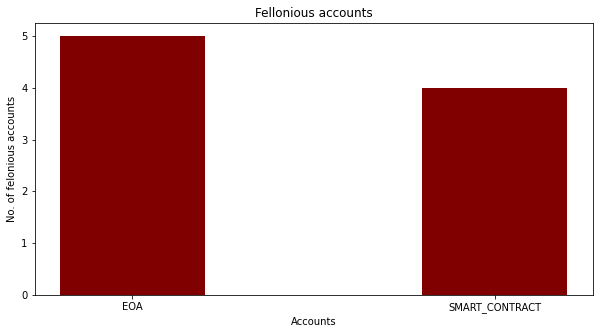

In [283]:

data = {'EOA': len(eoa_df), 'SMART_CONTRACT': len(sc_df)}
types = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(types, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Accounts")
plt.ylabel("No. of felonious accounts")
plt.title("Fellonious accounts")
plt.show()

## 3.4 Feature Engineering

### 3.4.1 EOA Feature Extraction

In [127]:
df5 = df4[(df4.type == "EOA")]
df5.shape[0]

7

### 3.4.2 EOA Feature Dimensionality Reduction

### 3.4.3 Smart Contract Analysis

In [19]:
import datetime
import numpy as np

class SmartContract:
    
    def __init__(self,address,transactions):
        self.address = address.lower()
        self.transactions = transactions
    
    def getSmartContractAddress(self):
        return self.address

    def getSmartContractTransactions(self):
        return self.transactions
    
    def f1_contract_creation_time(self):
        return self.transactions[0]['timeStamp']   
    
    def f2_transaction_fee_spent_contract_creation(self):
        return self.transactions[0]['gas']
    
    def f3_percentage_gas_used_contract_creation(self):
        return 100*(int(self.transactions[0]['gasUsed'])/int(self.transactions[0]['gas']))

    def f4_gas_price_contract_creation(self):
        return self.transactions[0]['gasPrice']
    
    def f5_first_contract_invoke_time(self):
        return self.transactions[1]['timeStamp']
    
    def f6_last_contract_invoke_time(self):
        return self.transactions[len(self.transactions)-1]['timeStamp']

    def f7_active_duration(self):
        a = datetime.datetime.fromtimestamp(int(self.f5_first_contract_invoke_time()))
        b = datetime.datetime.fromtimestamp(int(self.f6_last_contract_invoke_time()))
        return ((b-a).total_seconds())
    
    def f8_total_invocations(self):
        return len(self.transactions)-1

    def f9_total_unique_invocations(self):
        tx = [x['from']+"-"+ x['to'] for x in self.transactions]
        numpy_array_tx = np.array(tx)
        return len(np.unique(numpy_array_tx))

    def f10_avg_gas_used_contract_invocations(self):
        total_gas_used = sum([int(x['gasUsed']) for x in self.transactions if x['contractAddress']==""])
        return total_gas_used/self.f8_total_invocations()
    
    def f11_total_gas_price_contract_invocations(self):
        total_gas_price = sum([int(x['gasPrice']) for x in self.transactions if x['contractAddress']==""])
        return total_gas_price
    
    def f12_avg_gas_price_contract_invocations(self):
        total_gas_price = sum([int(x['gasPrice']) for x in self.transactions if x['contractAddress']==""])
        return total_gas_price/self.f8_total_invocations()
    
    def f13_total_tx_fee_contract_invocations(self):
        total_tx_fee = sum([int(x['gas']) for x in self.transactions if x['contractAddress']==""])
        return total_tx_fee
    
    def f14_avg_tx_fee_contract_invocations(self):
        total_tx_fee = sum([int(x['gas']) for x in self.transactions if x['contractAddress']==""])
        return total_tx_fee/self.f8_total_invocations()
    
    def f15_total_ether_contract_invocations(self):
        total_ether = sum([int(x['value']) for x in self.transactions if x['contractAddress']==""])
        return total_ether
    
    def f16_average_ether_contract_invocations(self):
        total_ether = sum([int(x['value']) for x in self.transactions if x['contractAddress']==""])
        return total_ether/self.f8_total_invocations()
    
    def f17_total_gas_used_contract_invocations(self):
        total_gas_used = sum([int(x['gasUsed']) for x in self.transactions if x['contractAddress']==""])
        return total_gas_used
    
    def f18_avg_gas_used_contract_invocations(self):
        total_gas_used = sum([int(x['gasUsed']) for x in self.transactions if x['contractAddress']==""])
        return total_gas_used/self.f8_total_invocations()

### 3.4.4 Smart Contract Feature Dimensionality Reduction

# 4. Training

## 4.2 Data Splitting
We split the dataset into 70%-30% for the training and testing of our model.

## 4.3 k-NN Classifier

## 4.4 Decision Tree Classifier

## 4.5 Random Forest Classifier

## 4.6 XGBoost Classifier

# 5. Analysis/Evaluation

## 5.1 Experimental results for EOA analysis

## 5.2 Experimental results for Smart Contract analysis